In [2]:
import sys
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from model import preprocess_data
from model.train import HST

Using TensorFlow backend


# Load model and dataset to test

In [4]:
synthetic_dataset =  "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_synth"
jrdb_original = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_orig"
jrdb_odometry_processed = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_odom"
eth_augmented = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_eth_aug"
crowdbot_odom = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test_data"
crowdbot_orig = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test"

test_dataset =  tf.data.Dataset.load(crowdbot_odom)
test_dataset = tf.data.Dataset.unbatch(test_dataset)
test_dataset = test_dataset.batch(1000)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10221441867834611256


In [20]:
synthetic_dataset_model =  "/home/annalena/PedestrianTrajectoryPrediction/trained_models/trained_synth/ckpts_best/ckpt"
# jrdb_original =  TODO
jrdb_odometry_processed = "/home/annalena/PedestrianTrajectoryPrediction/trained_models/odom_aug/ckpts_best/ckpt"
eth_augmented = "/home/annalena/PedestrianTrajectoryPrediction/trained_models/eth_aug/ckpts_best/ckpt"
eth_finetuned = "/home/annalena/PedestrianTrajectoryPrediction/trained_models/eth_tune_synth/ckpts_best/ckpt"


model = HST(15)
optimizer = tf.keras.optimizers.Adam()
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(eth_augmented) # put trained model here
checkpoint.restore(latest_checkpoint)

# Predict and show examples

In [6]:
%matplotlib inline

In [21]:
def plot_example(input, pred, idx, mode):

    ground_truth = input[0][idx][:,:2].numpy()
    prediction = pred["position"][idx,:,mode,:2].numpy()

    plt.plot(ground_truth[:6,0], ground_truth[:6,1], 'ro-', label='Ground Truth Input')
    plt.plot(ground_truth[6:,0], ground_truth[6:,1], 'rx-', label='Ground Truth Forecast')
    plt.plot(prediction[6:,0], prediction[6:,1],'bo-', label='Model Forecast')
    plt.show()

In [23]:
for (batch_x1, batch_x2) in test_dataset.take(1):
    input_batch = (batch_x1, batch_x2)
    output_dict, pred = model(input_batch, training=False)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10221441867834611256


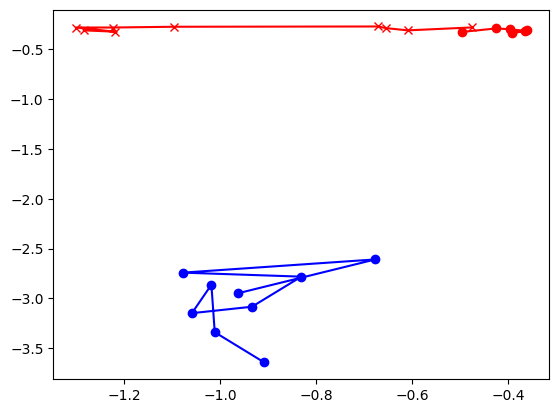

In [24]:
idx = 19
best_mode = np.argmax(output_dict["mixture_logits"][idx].numpy())
plot_example(input_batch, pred, idx, mode=best_mode)

# Accuracy Metrics

Mean ADE and Mean FDE

In [17]:
def calculate_meanADE(ground_truth, predictions, dim):
        predicted_positions = predictions[:, :, :dim]
        displacement_errors = np.linalg.norm(ground_truth - predicted_positions, axis=2)
        ADE = np.mean(np.mean(displacement_errors, axis=1))
        return ADE

def calculate_meanFDE(ground_truth, predictions, dim):
        predicted_positions = predictions[:, :, :dim]
        final_displacement_errors = np.linalg.norm(ground_truth[:, -1] - predicted_positions[:, -1], axis=1)
        FDE = np.mean(final_displacement_errors)
        return FDE

In [25]:
def get_best_pred(pred):
    best_pred = []
    for i in range(1000):
        best_mode = np.argmax(output_dict["mixture_logits"][i].numpy())
        best_pred.append( pred["position"][i,:,best_mode,:2].numpy())
    return np.asarray(best_pred)
best_pred = get_best_pred(pred)

In [26]:
meanADE = calculate_meanADE(input_batch[0].numpy()[:,:,:2], best_pred, dim=2)
meanFDE = calculate_meanFDE(input_batch[0].numpy()[:,:,:2], best_pred, dim=2)
print("mean ADE", meanADE)
print("mean FDE", meanFDE)

mean ADE 2.7258944221760384
mean FDE 3.217703575973748
